# Practical Data Visualization with Python

By: [Paul Jeffries](https://twitter.com/ByPaulJ)

## High-Level Overview of Content:

Below you'll find a brief outline of the content contained in the four sections of this seminar. Thereafter, we'll go through a brief couple of setup steps, followed by the material for each of the four major sections. 

### Why We Visualize

1. The power of visual data representation and storytelling. 
2. A few principles and heuristics of visualization.
3. The building blocks of visualization explored.

### Overview of Python Visualization Landscape

1. Intro to the visualization ecosystem: python's Tower of Babel.
2. Smorgasbord of packages explored through a single example viz.
3. Quick & dirty (and subjective) heuristics for picking a visualization package.

### Statistical Visualization in the Wild

1. Example business use case of data visualization: debt-to-income ratios explored.
    1. Observational:
        - mean, median, and variance
        - distributions
    2. Inferential:
        - two-sample t-test
        - KS test

### Library Deep-Dive (Plotly)

1. Quick and simple data visualizations with Plotly Express.
    - Mark types, colors, facets, etc.
2. Additional control and complexity with base Plotly.
    - Choropleth maps 
    - Heatmaps 

## Setup

In [9]:
%%capture

# capturing above because there are a few useless warnings that might pop up, version-depending
# basic packages
import numpy as np
import pandas as pd
import datetime

# for data cleaning
from janitor import clean_names, remove_empty

# packages for viz
import plotly_express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.io as pio

In [10]:
# there are a few warnings I want to silence throughout that are due to unimportant np deprecations 
np.warnings.filterwarnings('ignore')

In [11]:
# store the datetime of the most recent running of this notebook as a form of a log
most_recent_run_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
f"This notebook was last executed on {most_recent_run_datetime}"

'This notebook was last executed on 2019-07-20 19:39'

In [12]:
# pulling in our main data; for more info on the data, see the "data_prep_nb.ipynb" file
main_df = pd.read_csv(filepath_or_buffer='../data/jan_and_dec_17_acqs.csv')

# taking a peek at our data
main_df.head()

,loan_id,orig_chn,seller_name,orig_rt,orig_amt,orig_trm,orig_dte,frst_dte,oltv,ocltv,...,occ_stat,state,zip_3,mi_pct,product_type,cscore_c,mi_type,relocation_flg,cscore_min,orig_val
0,100020736692,B,"CALIBER HOME LOANS, INC.",4.875,492000,360,12/2017,02/2018,75,75,...,I,CA,920,NaN,FRM,NaN,NaN,N,757.0,656000.000000
1,100036136334,R,OTHER,2.750,190000,180,12/2017,01/2018,67,67,...,P,MD,206,NaN,FRM,798.0,NaN,N,797.0,283582.089552
2,100043912941,R,OTHER,4.125,68000,360,12/2017,02/2018,66,66,...,P,OH,432,NaN,FRM,NaN,NaN,N,804.0,103030.303030
3,100057175226,R,OTHER,4.990,71000,360,12/2017,02/2018,95,95,...,P,NC,278,30.0,FRM,NaN,1.0,N,696.0,74736.842105
4,100060715643,R,OTHER,4.500,180000,360,12/2017,02/2018,75,75,...,I,WA,983,NaN,FRM,NaN,NaN,N,726.0,240000.000000


## Why We Visualize

**more detailed outline below until all the content can be added to the notebook**

- Intro comments about not just jumping into the sea of tools. 
    - Credit to [Jake VanderPlas' talk from PyCon 2019](https://www.youtube.com/watch?v=vTingdk_pVM).
- Slide about "Anscombe's Quartet" (see other repo)
- Updated slide with Dino Dozen dataset.
- So what did we really "do" when we visualized these data points in order to glean additional information?
    - Answer to "why we visualize?": because encoding data into a visual representation can often lead to insights that we might not glean intuitively, if at all, without visualization. 
- Show an example of encoding: dino dozen, with X, Y, and color.
    - Follow that with an example of many potential encodings (facet, size, shape, color, all-in-one)
- Go over Bertin's book on encodings, and levels of organization, recognizing what types of encodings are better suited for communicating different levels of information. 
    - Bertin or VanderPlas' lists though are not exhaustive, nor should they be taken as irrefutable. It's the concept that matters. 
    - Before starting a visualization one should always ask:
        - What type of information am I trying to encode?
        - As such, what type of ecoding would most clearly and powerfully communicate that information?
        - Simple heuristic here that I find helpful: does the design of this visualization call the attention of the observer seemlessly to the most important features of the dataset
- Putting it all together with the "building blocks of visualization":
    - Data
    - Transformation
    - Marks
    - Encoding
    - Scale
    - Guides
    - Reference here to L. Wilkinson's book and Hadley's Book
    - Provide example highlighting each of the above building blocks
- Ending example with Fannie Mae data of a visualization problem with one mediocre solution and one good one:
    - Problem of FICO distributions by lender. 

### Theory Before Packages

...

### Dissection of a Visualization: Two Examples Explored

Now that we have explored the building blocks of visualization and learned some heuristics to help us with best practices, let's apply this to an example use case.

Imagine that one of our risk managers wants to understand the FICO distributions of a handful of lenders. They've also added that all they really care about is understanding the relative distributional differences: i.e., how does lender 1's distribution differ from lender 2's, and so on. For the sake of this analysis, we'll just (arbitrarily) pick the top 3 lenders by January 2017 origination volume. 

How might you go about visualizing these distributional differences? We'll start with an example of a mediocre visualization that, while helpful, is likely not optimal given the ask. Then we'll proceed to a better visualization that more powerfully and clearly communicates the information we want. 

In [13]:
# pre-visualization data prep:
# creating a df with just the january origination volume of our top 10 lenders by volume in that month

# filtering to just january acquisitions and dropping "OTHER" sellers
jan_originations_only = main_df.loc[(main_df['orig_dte'] == '01/2017') & (main_df['seller_name'] != 'OTHER'),:]

# getting the top 3 lenders by volume
top_3_lenders = (
    jan_originations_only
    .groupby('seller_name')
    .size()
    .reset_index(name='counts')
    .sort_values('counts', ascending=False)
    .head(3)
)['seller_name']

# making a df of just the records from the top 3 lenders by volume, keeping just the needed columns: seller name and FICO
top_3_lenders_jan_origs_df = jan_originations_only.loc[main_df['seller_name'].isin(top_3_lenders),['seller_name','cscore_min']]

# inspecting the data we'll be working with for this example
top_3_lenders_jan_origs_df.head()

,seller_name,cscore_min
2803,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",724.0
3208,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",744.0
8514,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",695.0
10496,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",738.0
10788,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",701.0


Below is an example of a mediocre 1st pass at the visualization problem described above. For this viz. I'll make use of the [Plotly Express](https://plot.ly/python/plotly-express/) package (more on this later; the purpose of this section isn't to focus on package-specific idosyncracies) to make 3 FICO histograms--one for each seller. 

- Some of the weaknesses of this viz include:
    - All of the "sloppy" legend work:
        - lack of title
        - sloppy labels (facets, x-axis, y-axis)
    - Use of histogram (counts) makes it harder to compare the overall FICO distributions because volume differences can be distracting.
    - Use of facets complicates comparisons by forcing "bouncing eyes".

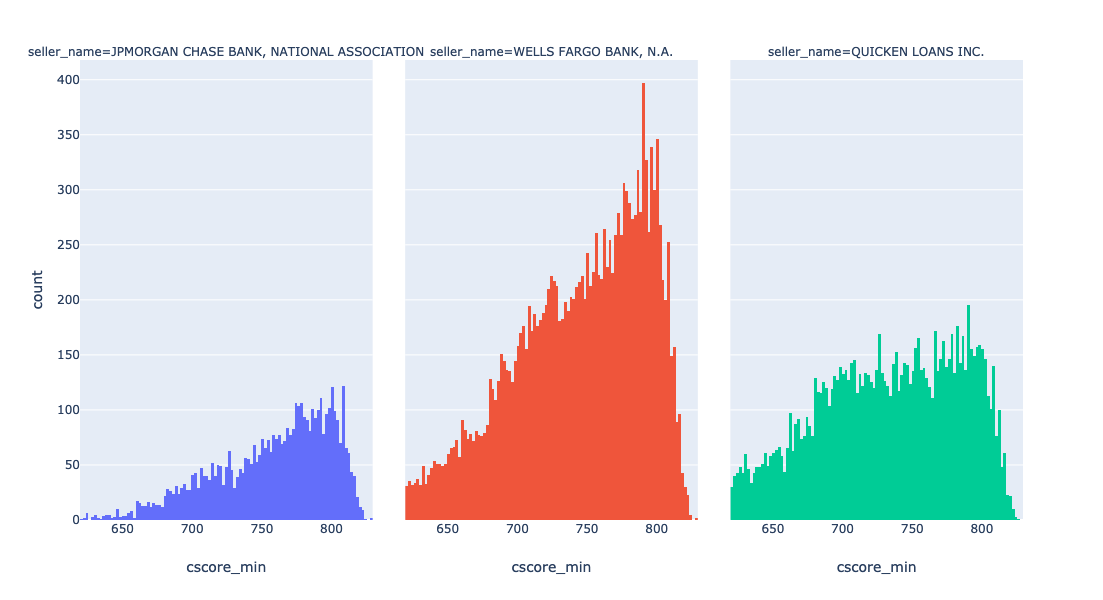

In [14]:
# medicore example -- facetted histogram:

# creates a histogram facetted by seller with Plotly Express
lender_fico_hist = px.histogram(
    data_frame = top_3_lenders_jan_origs_df,
    x = 'cscore_min',
    color = 'seller_name',
    facet_col = 'seller_name',
    height = 600,
    width = 1200
)

# dropping the color legend
lender_fico_hist.update(
    layout_showlegend=False,
)

In [15]:
# saving out the px figure; I'm doing this in a separate cell because saving plotly figures requires orca, which some might not have
# for details on how to get orca working, see: https://medium.com/@plotlygraphs/plotly-py-end-of-summer-updates-5422c98b9058
pio.write_image(lender_fico_hist, file='../media/fico_seller_hist_plot.png')

Below is an example of a crisper representation of the data in our use case. I'll make use of kernel density plot ([aka PDF](https://en.wikipedia.org/wiki/Probability_density_function)), which is a great chart type if you care about looking at the overall shape of distributions. For now, it's not important to fully understand the math behind the smoothing visible in the KDE plot, but if you're interested, check out [this explanation of the meaning of the y-axis](https://stats.stackexchange.com/questions/48109/what-does-the-y-axis-in-a-kernel-density-plot-mean), as well as this [overall explanation of KDE plots](https://www.homeworkhelponline.net/blog/math/tutorial-kde). The quick tl:dr is that if you pick two points along the x-axis, the area under the curve between them is the probabilty of finding a value in that range (or in empirical cases, the actual observed rate of occurence of a value in that range), but again, given the stated problem in this use case, those details are less important than the overall shape of the distributions. 

- Some of the strengths of this viz include:
    - The use of color hue makes it easy to differenciate between sellers at a glance.
    - The lack of facets and shared scale facilitates relative comparisons of the distributions by avoiding "bouncing eyes".
    - The choice of a KDE plot as the mark type removes the noise inherent to a histogram.

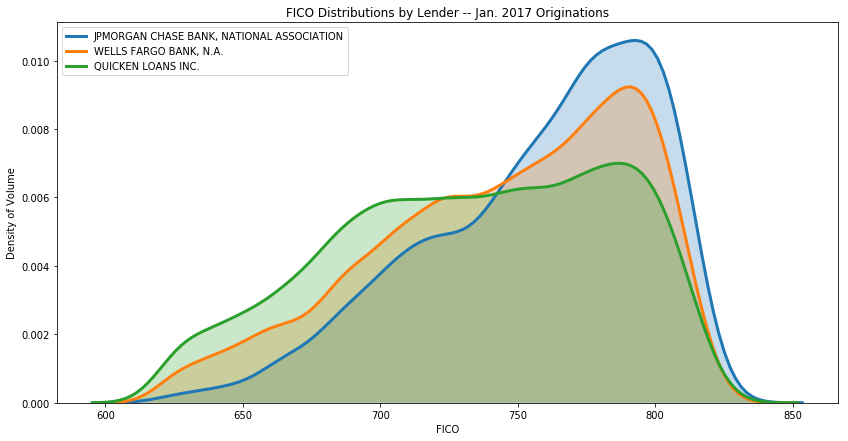

In [16]:
# higher-quality viz. example -- overlayed KDE plot:

# setting our figure size
plt.figure(figsize=(14, 7))

# plotting one KDE plot for each seller
for seller in top_3_lenders_jan_origs_df['seller_name'].unique() :
    fico_dist_ax = sns.distplot(
        top_3_lenders_jan_origs_df.loc[top_3_lenders_jan_origs_df['seller_name']== seller,'cscore_min'],
        hist = False,
        kde = True,
        kde_kws = {
            'shade': True,
            'linewidth':3
        },
        label = seller
    )
;

# setting the axes labels and title
fico_dist_ax.set(
    xlabel="FICO", 
    ylabel="Density of Volume", 
    title ="FICO Distributions by Lender -- Jan. 2017 Originations"
)

;
# saving out the plot
plt.savefig(fname = '../media/fico_seller_dist_plot.png')

## Overview of Python Visualization Landscape 

Now that we've learned some 

## Statistical Visualization in the Wild

## Library Deep-Dive (Plotly)

to do's:

- add detailed outline for stats in the wild so others can contribute
- do homework outline 